In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import glob
from scipy import stats
import datetime as dt
from tensorflow.keras import Sequential , optimizers
from tensorflow.keras.layers import Dropout,Dense,LSTM
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

## 10.1 DataPreparation

#### 10.1.1 Data Preparation 

In [2]:
# Load data from csv 3 files
# acceleration.txt, heartrate.txt, labeled_sleep.txt

ACC    = pd.read_csv('acceleration.txt', sep = ' ', names=['timedelta', 'accX', 'accY', 'accZ'])
HeartR = pd.read_csv('heartrate.txt', sep = ',', names=['timedelta', 'heartrate'])
SleepL = pd.read_csv('labeled_sleep.txt', sep = ' ', names=['timedelta', 'sleep'])

In [3]:
# Check 'timedelta' max(), min() of ACC, HeartR, SleepL (ช่วงเวลาที่มีข้อมูลใกล้กัน)

ACC_max_date = ACC['timedelta'].max()
ACC_min_date = ACC['timedelta'].min()

HeartR_max = HeartR['timedelta'].max()
HeartR_min = HeartR['timedelta'].min()

SleepL_max = SleepL['timedelta'].max()
SleepL_min = SleepL['timedelta'].min()

In [4]:
print(f'ACC start: {ACC_min_date} ACC end: {ACC_max_date}')
print(f'HeartR start: {HeartR_min} HeartR end: {HeartR_max}')
print(f'SleepL start: {SleepL_min} SLeepL end: {SleepL_max}')

ACC start: -124489.16105 ACC end: 17643.046417
HeartR start: -556410.36066 HeartR end: 16980.47229
SleepL start: 0 SLeepL end: 16980


In [5]:
 # select only intersected timedelta (ACC, HeartR, SleepL) (ช่วงเวลาที่มีข้อมูลใกล้กัน) #เลือกขอบ
ACC_new = ACC[(ACC['timedelta'] > SleepL_min) & (ACC['timedelta'] < SleepL_max)]
HeartR_new = HeartR[(HeartR['timedelta']> SleepL_min) & HeartR['timedelta']< SleepL_max]
SleepL_new = SleepL[(SleepL['timedelta']> SleepL_min) & SleepL['timedelta']< SleepL_max]

In [6]:
# Convert to datetime and round to second,
# ------------ Rounding ACC (Rounding to 1 sec) -------------------------------
ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], unit='s').round('1s'))
ACC_new

,timedelta,accX,accY,accZ
98777,0 days 00:00:00,-0.234650,0.905975,0.362747
98778,0 days 00:00:00,-0.231232,0.893265,0.371613
98779,0 days 00:00:00,-0.227814,0.915848,0.369049
98780,0 days 00:00:00,-0.240524,0.919159,0.352890
98781,0 days 00:00:00,-0.240448,0.889175,0.350143
...,...,...,...,...
948796,0 days 04:43:00,-0.442413,-0.527573,0.723450
948797,0 days 04:43:00,-0.441925,-0.527573,0.721985
948798,0 days 04:43:00,-0.441437,-0.526108,0.721985
948799,0 days 04:43:00,-0.443405,-0.525116,0.723434


In [7]:
# Average rounding duplicated time
df_acc_X = ACC_new.groupby('timedelta')['accX'].mean().reset_index()
df_acc_Y = ACC_new.groupby('timedelta')['accY'].mean().reset_index()
df_acc_Z = ACC_new.groupby('timedelta')['accZ'].mean().reset_index()
ACC = pd.concat([df_acc_X, df_acc_Y, df_acc_Z], axis=1)
ACC = ACC.loc[:,~ACC.columns.duplicated()].copy() #ตัด duplicate columns(timedelta)
ACC

,timedelta,accX,accY,accZ
0,0 days 00:00:00,-0.243203,0.895372,0.367591
1,0 days 00:00:01,-0.240757,0.873826,0.415446
2,0 days 00:00:02,-0.244620,0.883943,0.387026
3,0 days 00:00:03,-0.248036,0.902427,0.347812
4,0 days 00:00:04,-0.241778,0.912946,0.321502
...,...,...,...,...
16976,0 days 04:42:56,-0.442763,-0.525892,0.722950
16977,0 days 04:42:57,-0.441990,-0.525476,0.723410
16978,0 days 04:42:58,-0.441581,-0.525116,0.724003
16979,0 days 04:42:59,-0.442283,-0.525849,0.723265


In [8]:
# ------------ Rounding Heart Rate (Rounding to 1 sec) -------------------------------
HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'],unit='s').round('1s'))

In [9]:
# Resampling every 1s with median with ffill
resample_rule = '1s'
HeartR_new2 = HeartR_new.set_index('timedelta').resample(resample_rule,).median().ffill()

In [10]:
# ------------ Rounding Sleep Label (Rounding to 1 sec) -------------------------------
SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'],unit='s').round('1s'))

In [11]:
# Resampling every 1s with median with ffill
resample_rule = '1s'
SleepL_new2 = SleepL_new.set_index('timedelta').resample(resample_rule,).median().ffill()
SleepL_new2.replace({-1:0},inplace=True)

In [12]:
# ------------Merge All Data -------------------------------
df = pd.merge_asof(ACC, HeartR_new2, on='timedelta')
df = pd.merge_asof(df, SleepL_new2, on='timedelta')

In [13]:
# Fill NA
# Heart rate
# Fillna() # using median()
heart_mean = df.heartrate.mean()
df.heartrate.fillna(heart_mean,inplace=True)
# # Sleep Label
# Fillna() # with 0
df.sleep.fillna(0,inplace=True)
# # Drop column
df.drop(columns='timedelta',inplace=True)
df

,accX,accY,accZ,heartrate,sleep
0,-0.243203,0.895372,0.367591,87.0,0.0
1,-0.240757,0.873826,0.415446,87.0,0.0
2,-0.244620,0.883943,0.387026,87.0,0.0
3,-0.248036,0.902427,0.347812,87.0,0.0
4,-0.241778,0.912946,0.321502,87.0,0.0
...,...,...,...,...,...
16976,-0.442763,-0.525892,0.722950,76.0,0.0
16977,-0.441990,-0.525476,0.723410,76.0,0.0
16978,-0.441581,-0.525116,0.724003,76.0,0.0
16979,-0.442283,-0.525849,0.723265,76.0,0.0


#### 10.1.2 Simple Moving Average (SMA) and Create 2D feature

In [14]:
# ------------Simple Moving Average (SMA) ------------------------------ 
feature_columns = ['accX', 'accY', 'accZ', 'heartrate']
label_columns = ['sleep']
df_feature = df[feature_columns]
df_feature_SMA = pd.DataFrame()
df_feature_SMA['accX'] = df_feature['accX'].rolling(5, min_periods=1).mean()
df_feature_SMA['accY'] = df_feature['accY'].rolling(5, min_periods=1).mean()
df_feature_SMA['accZ'] = df_feature['accZ'].rolling(5, min_periods=1).mean()
df_feature_SMA['heartrate'] = df_feature['heartrate'].rolling(5, min_periods=1).mean()

In [15]:
# Standardized data
feature_columns = ['accX', 'accY', 'accZ', 'heartrate']
label_columns = ['sleep']
standard_scaler = StandardScaler()
df[feature_columns] = standard_scaler.fit_transform(df_feature_SMA[feature_columns])

df_feature = df[feature_columns]
df_label = df[label_columns]
df_feature

,accX,accY,accZ,heartrate
0,-0.589117,3.071108,0.699695,0.794356
1,-0.586064,3.039478,0.729243,0.794356
2,-0.588261,3.038837,0.727393,0.794356
3,-0.591491,3.052083,0.714363,0.794356
4,-0.590305,3.066209,0.700046,0.794356
...,...,...,...,...
16976,-1.085938,-1.101418,1.139230,-0.713978
16977,-1.085722,-1.101129,1.139208,-0.687973
16978,-1.085465,-1.100774,1.139306,-0.661967
16979,-1.085825,-1.101020,1.139113,-0.635961


In [16]:
# ------------ Train-Test-Split 2D features -------------------------------
# set sliding window parameter
slidingW = 100
stride_step = 5

df_feature2D = []
df_feature2D_T = []
df_label_new = np.array([])

for t in range(0 , len(df_label) - 96, stride_step ):
    F2d = df_feature[t : t + slidingW]
    df_feature2D.append(np.array(F2d))

    F2d_T = np.transpose(F2d)
    df_feature2D_T.append(np.array(F2d_T))

    Labels = stats.mode(df_label[t:t+slidingW ])
    df_label_new = np.append(df_label_new,Labels[0])

df_feature2D = np.array(df_feature2D)
df_feature2D_T = np.array(df_feature2D_T)

print(np.array(df_feature2D).shape)
print(np.array(df_feature2D_T).shape)

print(df_label_new.shape)

(3377, 100, 4)
(3377, 4, 100)
(3377,)


#### 10.1.3 Train Test Split

In [17]:
# ------------ Train-Test-Split 2D features -------------------------------
x_train, x_test, y_train, y_test = train_test_split(df_feature2D_T, df_label_new)


## 10.2 LSTM Model Training and Testing

#### 10.2.1 LSTM Model Parameters

In [18]:
# ------------ LSTM Architecture parameter -------------------------------
# Nlayer (LSTM, dense), Nnode, Activation
inRow = N_features = 4
inCol = Sliding_windows = 100

LSTM_L1 = 100 # try 200, 300, 400, 500, 1000
LSTM_L2 = 50 # try 50, 100, 150, 200, 250, 300
dropRate_L1 = 0.25
dropRate_L2 = 0.5
Activation = 'Softmax'
n_classes = 6 
Input_shape = (inRow, inCol)
Input_shape


(4, 100)

#### 10.2.2 LSTM Model Train Test

In [19]:
# ------------ Create LSTM Model -------------------------------
model = Sequential()
model.add(LSTM(LSTM_L1, return_sequences=True, input_shape=Input_shape))

model.add(Dropout(dropRate_L1 ))
model.add(LSTM(LSTM_L2 ))

model.add(Dropout(dropRate_L2))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-11-10 23:40:57.372727: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-10 23:40:57.373228: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 100)            80400     
                                                                 
 dropout (Dropout)           (None, 4, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 6)                 306       
                                                                 
Total params: 110,906
Trainable params: 110,906
Non-trainable params: 0
_________________________________________________________________


#### 10.2.3 LSTM Model Train Test

In [20]:
# ------------ Create Optimizer -------------------------------
model.compile( optimizer='adam',loss= tf.keras.losses.SparseCategoricalCrossentropy(),metrics=["acc"])

In [21]:
# ------ Train CNN using 2D feature--------------------------------------------
# Training the model
EP = 100
batch_size = 100 # try 20, 40, 60, 80, 100 (iteration)
history = model.fit(x_train, y_train, batch_size = batch_size, validation_data=(x_test, y_test), epochs=EP)

Epoch 1/100


2022-11-10 23:40:57.939278: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-10 23:40:59.340910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 23:40:59.581703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 23:40:59.675010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/26 [>.............................] - ETA: 50s - loss: 1.8023 - acc: 0.1200

2022-11-10 23:40:59.791937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 23:40:59.902933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - ETA: 0s - loss: 1.4414 - acc: 0.4479

2022-11-10 23:41:00.725293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 23:41:00.813456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 23:41:00.850153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 3s 41ms/step - loss: 1.4414 - acc: 0.4479 - val_loss: 1.1609 - val_acc: 0.5302
Epoch 2/100
26/26 [==============================] - 0s 17ms/step - loss: 1.1547 - acc: 0.5091 - val_loss: 1.0196 - val_acc: 0.6237
Epoch 3/100
26/26 [==============================] - 0s 17ms/step - loss: 1.0254 - acc: 0.5897 - val_loss: 0.8863 - val_acc: 0.6485
Epoch 4/100
26/26 [==============================] - 0s 17ms/step - loss: 0.8903 - acc: 0.6596 - val_loss: 0.7570 - val_acc: 0.7243
Epoch 5/100
26/26 [==============================] - 0s 18ms/step - loss: 0.7881 - acc: 0.7089 - val_loss: 0.6631 - val_acc: 0.7751
Epoch 6/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6900 - acc: 0.7484 - val_loss: 0.5919 - val_acc: 0.7669
Epoch 7/100
26/26 [==============================] - 0s 19ms/step - loss: 0.6129 - acc: 0.7796 - val_loss: 0.5423 - val_acc: 0.7834
Epoch 8/100
26/26 [==============================] - 1s 21ms/step - loss: 0.5511 - acc: 

## 10.3 LSTM Performance Measurement

#### Performance of LSTM Model

In [22]:
# LSTM prediction for Option #1 and Option #2
LSTM_pred = model.predict(x_test)
# Get classID from max prob(LSTM_pred)
df_pred = pd.DataFrame(LSTM_pred)
# df_class => use dataframe -> idxmax(axis=1)

LSTM_pred = np.argmax(model.predict(x_test),axis=1)
df_pred

13/27 [=============>................] - ETA: 0s 

2022-11-10 23:41:43.565076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 23:41:43.635662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 23:41:43.669980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 0s 4ms/step


,0,1,2,3,4,5
0,0.000013,0.000031,0.000002,0.000003,4.170926e-06,9.999458e-01
1,0.335874,0.165404,0.497175,0.000840,1.990732e-04,5.085385e-04
2,0.000133,0.000002,0.001401,0.998457,3.854784e-06,3.234919e-06
3,0.000016,0.000108,0.997559,0.002310,4.412637e-07,6.272422e-06
4,0.000067,0.000026,0.999781,0.000124,3.359482e-07,6.590631e-07
...,...,...,...,...,...,...
840,0.000007,0.000020,0.000002,0.000002,3.350952e-06,9.999651e-01
841,0.335430,0.236262,0.426770,0.000853,2.115497e-04,4.737480e-04
842,0.000007,0.000008,0.000003,0.000001,3.790406e-06,9.999763e-01
843,0.000088,0.000028,0.999744,0.000139,4.033428e-07,6.718469e-07


In [23]:
# ------------ View Confusion Matrix, Classification Report -------------------------------
print('----- Confusion matrix of LSTM -----')
print(confusion_matrix(y_test,LSTM_pred))
print('----- Classification matrix of LSTM -----')
print(classification_report(y_test,LSTM_pred))


----- Confusion matrix of LSTM -----
[[126   1   7   0   0]
 [  5  19  15   0   0]
 [  9   2 242   5   4]
 [  1   0  17 209   0]
 [  0   2   2   0 179]]
----- Classification matrix of LSTM -----
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.92       134
         1.0       0.79      0.49      0.60        39
         2.0       0.86      0.92      0.89       262
         3.0       0.98      0.92      0.95       227
         5.0       0.98      0.98      0.98       183

    accuracy                           0.92       845
   macro avg       0.90      0.85      0.87       845
weighted avg       0.92      0.92      0.91       845



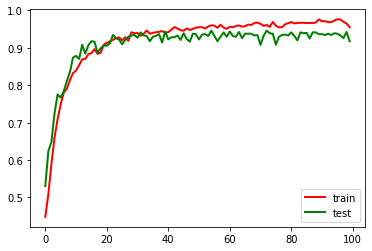

In [25]:
plt.plot(history.history['acc'],'r',linewidth=2,label='train')
plt.plot(history.history['val_acc'],'g',linewidth=2 , label='test')
plt.legend()
plt.show()

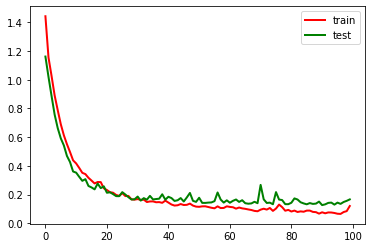

In [26]:
plt.plot(history.history['loss'],'r',linewidth=2,label='train')
plt.plot(history.history['val_loss'],'g',linewidth=2, label='test')
plt.legend()
plt.show()